In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.utils import resample
from matplotlib.ticker import PercentFormatter

In [23]:
apachevars = pd.read_csv('data/apache_features.csv')

gcs = pd.read_csv('data/patient_motor.csv')
gcs = gcs[gcs['observationoffset'] > -1]
gcs['observationoffset'] = gcs['observationoffset'] / 60
final_gcs_id = gcs.groupby('patientunitstayid')['observationoffset'].transform(max) == gcs['observationoffset']
final_gcs = gcs[final_gcs_id].drop(['observationoffset', 'Key', 'origin'], axis = 1)

In [24]:
pd.set_option('display.max_columns', None)
#fix X
X = apachevars.copy()
X = X.drop(['Unnamed: 0', 'apacheapsvarid', 'diagnosisid', 'patientunitstayid.1', 'activeupondischarge', 'diagnosisstring', 'icd9code', 'diagnosispriority'], axis = 1)
X = X.sort_values('diagnosisoffset').drop_duplicates(subset = 'patientunitstayid').drop('diagnosisoffset', axis = 1)

combined = X.merge(final_gcs, on = 'patientunitstayid', how = 'inner')
display(combined)
final_gcs = combined.loc[:, ['patientunitstayid', 'Value']]
X = combined.drop(['patientunitstayid','Value'], axis = 1)

,patientunitstayid,intubated,vent,dialysis,eyes,motor,verbal,meds,urine,wbc,temperature,respiratoryrate,sodium,heartrate,meanbp,ph,hematocrit,creatinine,albumin,pao2,pco2,bun,glucose,bilirubin,fio2,Value
0,1324793,0,0,0,1,2,1,0,-1.0000,4.80,34.7,4.0,159.0,114.0,144.0,7.410,23.2,1.17,2.8,96.4,35.1,11.0,210.0,1.4,30.0,1.0
1,1104486,0,0,0,4,6,4,0,1633.4784,-1.00,36.5,26.0,-1.0,115.0,139.0,-1.000,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6.0
2,826641,1,0,0,1,1,1,0,-1.0000,12.70,36.7,10.0,145.0,124.0,157.0,7.371,29.2,1.27,3.0,388.0,39.9,22.0,218.0,0.3,100.0,6.0
3,1087641,0,0,0,4,6,5,0,1868.4864,10.27,37.5,4.0,135.0,112.0,64.0,-1.000,38.4,0.60,-1.0,-1.0,-1.0,7.0,158.0,-1.0,-1.0,6.0
4,1129530,1,1,0,1,1,1,0,2614.2912,16.25,39.7,33.0,140.0,144.0,56.0,7.431,30.0,0.70,-1.0,527.0,31.5,8.0,143.0,-1.0,100.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2403,3112842,0,0,0,1,4,1,0,1631.4912,4.50,36.5,35.0,141.0,153.0,56.0,-1.000,25.3,0.17,-1.0,-1.0,-1.0,11.0,60.0,-1.0,-1.0,6.0
2404,3142740,1,1,0,1,4,1,0,2904.5952,10.70,36.5,4.0,138.0,118.0,128.0,7.520,32.8,0.46,-1.0,113.0,33.0,4.0,180.0,-1.0,30.0,6.0
2405,3080683,0,0,0,2,5,4,0,3351.7152,13.90,37.0,28.0,133.0,108.0,42.0,-1.000,34.5,5.43,-1.0,-1.0,-1.0,49.0,180.0,-1.0,-1.0,6.0
2406,3092375,0,0,0,4,6,4,0,1630.1088,7.00,37.3,30.0,127.0,120.0,56.0,-1.000,31.5,1.10,3.1,-1.0,-1.0,28.0,110.0,0.9,-1.0,4.0


In [49]:
from sklearn.preprocessing import StandardScaler
target_gcs = final_gcs['Value'].values 

X = X.replace(-1.0, np.nan)
trainX, testX, trainY, testY = train_test_split(X, target_gcs, test_size=0.2)
trainY, testY = trainY.flatten(), testY.flatten()

scaler = StandardScaler()
scaler.fit(trainX)
trainX = scaler.transform(trainX)
testX = scaler.transform(testX)
trainX = pd.DataFrame(trainX).apply(lambda x: x.fillna(x.mean()),axis=0).values
testX = pd.DataFrame(testX).apply(lambda x: x.fillna(x.mean()),axis=0).values


resampling = 'over'
if resampling == 'over':
    positive = np.argwhere(trainY.flatten() < 6).flatten()
    negative = np.argwhere(trainY.flatten() == 6).flatten()
    
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_positive = resample(X_positive, replace=True, n_samples=X_negative.shape[0])
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]
    
scaler = StandardScaler()
scaler.fit(trainX)
trainX = scaler.transform(trainX)
testX = scaler.transform(testX)




In [50]:
testY_mod = testY.copy()
testY_mod[testY < 6] = 0
testY_mod[testY == 6] = 1

trainY_mod = trainY.copy()
trainY_mod[trainY < 6] = 0
trainY_mod[trainY == 6] = 1

# train model
clf = LogisticRegression(max_iter=100, penalty='elasticnet', l1_ratio=0.5,
                         solver='saga', C=0.1)
clf.fit(trainX, trainY_mod)
print("Train Score:", clf.score(trainX, trainY_mod))

Train Score: 0.8012088650100738


Test Score: 0.8049792531120332
AUC: 0.8078785621158503


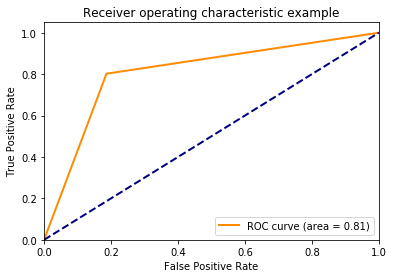

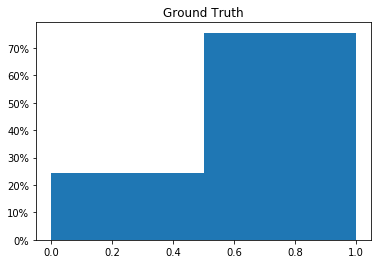

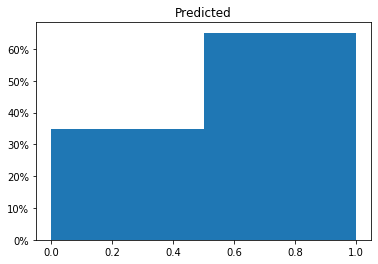

Text(33.0, 0.5, 'predicted')

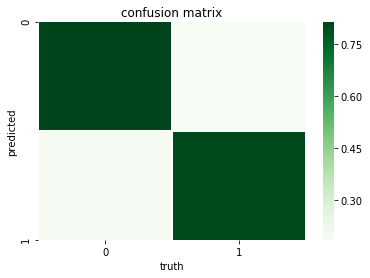

In [53]:
# test model
predY = clf.predict(testX)
print("Test Score:", clf.score(testX, testY_mod))

# get auc
auc = roc_auc_score(testY_mod, predY)
print("AUC:", auc)

# plot roc curve
fpr, tpr, _ = roc_curve(testY_mod, predY)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# class balance
plt.hist(testY_mod, bins=2, weights=np.ones(len(testY_mod)) / len(testY_mod))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Ground Truth")
plt.show()

plt.hist(predY, bins=2, weights=np.ones(len(predY)) / len(predY))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Predicted")
plt.show()

# heatmap
confusion = confusion_matrix(testY_mod, predY)
confusion = confusion / np.sum(confusion, axis=1)[:, None]
heatmap = sns.heatmap(confusion, linewidths=.5, cmap="Greens")
plt.title("confusion matrix")
plt.xlabel("truth")
plt.ylabel("predicted")